In [6]:
import os
import h5py
import fitsio
import numpy as np 
# --- desihub --- 
from desitarget.cmx import cmx_targetmask

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
dir_cmx = '/Users/ChangHoon/data/feasiBGS/cmx/'

In [31]:
# -- astorpy -- 
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, get_sun, get_moon

import warnings, astropy._erfa.core
from astropy.utils.iers import conf
conf.auto_max_age = None
warnings.filterwarnings('ignore', category=astropy._erfa.core.ErfaWarning)

kpno = EarthLocation.of_site('kitt peak')

def _get_obs_param(ra, dec, mjd):
    ''' get observing condition given tileid and time of observation 
    '''
    # get observing conditions
    coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg) 
    utc_time = Time(mjd, format='mjd') # observed time (UTC)          

    kpno_altaz = AltAz(obstime=utc_time, location=kpno) 
    coord_altaz = coord.transform_to(kpno_altaz)

    airmass = coord_altaz.secz

    # sun
    sun         = get_sun(utc_time) 
    sun_altaz   = sun.transform_to(kpno_altaz) 
    sun_alt     = sun_altaz.alt.deg
    sun_sep     = sun.separation(coord).deg # sun separation
    # moon
    moon        = get_moon(utc_time)
    moon_altaz  = moon.transform_to(kpno_altaz) 
    moon_alt    = moon_altaz.alt.deg 
    moon_sep    = moon.separation(coord).deg #coord.separation(self.moon).deg
            
    elongation  = sun.separation(moon)
    phase       = np.arctan2(sun.distance * np.sin(elongation), moon.distance - sun.distance*np.cos(elongation))
    moon_phase  = phase.value
    moon_ill    = (1. + np.cos(phase))/2.
    return airmass.value, moon_ill.value, moon_alt, moon_sep, sun_alt, sun_sep

Read in coadd of single exposure

In [32]:
f_coadd = 'coadd-70500-20200303-0-00052932.fits'
coadd = fitsio.read(os.path.join(dir_cmx, f_coadd))
wave = fitsio.read(os.path.join(dir_cmx, f_coadd), ext=2)
flux = fitsio.read(os.path.join(dir_cmx, f_coadd), ext=3)

Lets only keep the good sky fibers

In [33]:
is_good = (coadd['FIBERSTATUS'] == 0)
is_sky = ((coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SKY')) != 0)
print('%i sky fibers' % np.sum(is_sky)) 
print('%i good sky fibers' % np.sum(is_good & is_sky))

80 sky fibers
69 good sky fibers


Get MJD from GFA data that Aaron compiled and derive observing conditions

In [34]:
gfa = fitsio.read(os.path.join(dir_cmx, 'offline_all_guide_ccds_thru_20200315.fits'))

In [35]:
# match to GFA obs condition using NIGHT and EXPID
date    = int(f_coadd.split('-')[2]) 
tileid  = int(f_coadd.split('-')[1]) 
expid   = int(f_coadd.split('-')[-1].replace('.fits',''))

# match to GFA 
m_gfa = ((gfa['NIGHT'] == date) & (gfa['EXPID'] == expid))

# median MJD of GFA data 
mjd_mid = np.median(gfa['MJD'][m_gfa])

768 GFA exposure matches


In [36]:
airmass, moon_ill, moon_alt, moon_sep, sun_alt, sun_sep = _get_obs_param(coadd['TARGET_RA'][is_good & is_sky], coadd['TARGET_DEC'][is_good & is_sky], mjd_mid)

In [38]:
print('airmass %.4f' % np.median(airmass))
print('moon illumination %.4f' % moon_ill)
print('moon altitude %.4f' % moon_alt)
print('moon separation %.4f' % np.median(moon_sep))

airmass 1.1479
moon illumination 0.6481
moon altitude 35.7614
moon separation 34.0675


(0.0, 10.0)

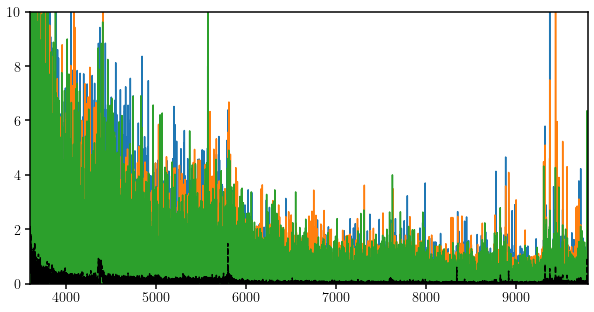

In [43]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(wave, flux[is_good & is_sky,:][0])
sub.plot(wave, flux[is_good & is_sky,:][5])
sub.plot(wave, flux[is_good & is_sky,:][20])
sub.plot(wave, np.average(flux[is_good & is_sky,:], axis=0), c='k', ls='--')
sub.set_xlim(3600, 9800)
sub.set_ylim(0., 10.)